# Отток клиентов

Необходимо спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Построить модель со значением метрики качества *F1* > 0.59.

### Описание данных

- RowNumber — индекс строки в данных;
- CustomerId — уникальный идентификатор клиента;
- Surname — фамилия;
- CreditScore — кредитный рейтинг;
- Geography — страна проживания;
- Gender — пол;
- Age — возраст;
- Tenure — количество недвижимости у клиента;
- Balance — баланс на счёте;
- NumOfProducts — количество продуктов банка, используемых клиентом;
- HasCrCard — наличие кредитной карты;
- IsActiveMember — активность клиента;
- EstimatedSalary — предполагаемая зарплата;
- Exited — факт ухода клиента.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

### Содержание

1. Подготовка данных
    - Изучение общей информации о данных
    - Дубликаты
    - Пропуски
    - Удаление ненужных признаков
    - Кодирование категориальных признаков
    - Масштабирование признаков
2. Исследование задачи
    - Баланс классов
    - Logistic Regression
    - Random Forest
3. Борьба с дисбалансом
    - Взвешивание классов
    - Upsamplimg
    - Downsampling
    - Изменение порога вероятности
4. Тестирование модели

### Загрузка библиотек и модулей

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.utils import shuffle
import numpy as np

## Подготовка данных

### Изучение общей информации о данных

In [2]:
data = pd.read_csv('/datasets/Churn.csv')

In [3]:
data.head(5)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [5]:
data.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


Видим, что присутствуют пропуски в столбце Tenure. Как появились: возможно в результатет того, что банк не получил информацию от клиентов по этому параметру, или возможно это техническая проблема, возникщая при выгрузке данных. Что за пропуски: пока не понятно. Что делать с пропусками: заполнить, чтобы не терять другую важную информациб об объектах и чтобы данные можно было использовать при работе с алгоритмами машинного обучения. Как заполнять: поскольку количество недвижимости да как-то коррелирует с тем, какой возраст у человека, то разобьем людей по возрастным группам. В каждой группе найдем моду по количеству недвижимости. И будем использовать эти значения мод для пропусков. Возрастные группы: молодежь (18-30), взрослые (31-55) и пожилые и старые (больше 55 лет).

Также в таблице присутствуют переменные, которые не несут никакой полезной информации для того, чтобы ее можно было использовать для предсказания: RowNumber, CustomerId, Surname. Поэтому можем просто выкинуть их из нашей таблицы.

Типы данных корректные плюс-минус. Можно только их оптимизировать, но это не настолько важно сейчас, чтобы делать.

Нужно проверить данные на момент наличия дубликатов.

### Дубликаты

In [6]:
data.duplicated().sum()

0

Дубликатов в данных нет.

### Пропуски

#### Tenure

In [7]:
def age_categories(age):
    if 18 <= age <= 30:
        return 'молодежь'
    elif 30 < age <= 55:
        return 'взрослые'
    return 'пожилые и старые'

In [8]:
data['age_category'] = data['Age'].apply(age_categories)

In [9]:
data.pivot_table(index='age_category', values='CustomerId', aggfunc='count')

,CustomerId
age_category,
взрослые,7232
молодежь,1968
пожилые и старые,800


Около 72% взрослы, около 20% молодежи и 8% пожилых и старых.

In [10]:
data.head(5)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,age_category
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1,взрослые
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0,взрослые
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1,взрослые
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0,взрослые
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0,взрослые


In [11]:
mode_adults = data.query('age_category == "взрослые"')['Tenure'].mode().tolist()[0]
print(f'Мода для взрослых: {mode_adults}')
mode_young = data.query('age_category == "молодежь"')['Tenure'].mode().tolist()[0]
print(f'Мода для молодежи: {mode_young}')
mode_elderly = data.query('age_category == "пожилые и старые"')['Tenure'].mode().tolist()[0]
print(f'Мода для старых и пожилых: {mode_elderly}')

Мода для взрослых: 2.0
Мода для молодежи: 4.0
Мода для старых и пожилых: 1.0


In [12]:
data.loc[(data['Tenure'].isnull() == True) & (data['age_category'] == 'молодежь'), 'Tenure'] = mode_young
data.loc[(data['Tenure'].isnull() == True) & (data['age_category'] == 'взрослые'), 'Tenure'] = mode_adults
data.loc[(data['Tenure'].isnull() == True) & (data['age_category'] == 'пожилые и старые'), 'Tenure'] = mode_elderly

In [13]:
data['Tenure'].isnull().sum()

0

Пропуски заполнены. Признак категории возраста оставим. Возможно он будет полезным в нашей модели.

### Удаление ненужных признаков

In [14]:
data = data.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

In [15]:
data.head(5)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,age_category
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1,взрослые
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0,взрослые
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1,взрослые
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0,взрослые
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0,взрослые


### Кодирование категориальных признаков

Кодировать категориальные признаки будем с помощью One-Hot-Encoding (прямое кодирование). Во время использования моделей решающего дерева и случайного леса будем использовать Ordinal Encoding.

#### One-Hot-Encoding

In [16]:
data_ohe = pd.get_dummies(data, drop_first=True)

In [17]:
data_ohe.head(5)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male,age_category_молодежь,age_category_пожилые и старые
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0,0,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0,0,0


#### Ordinal Encoding

In [18]:
ord_enc = OrdinalEncoder()
data_ordinal = pd.DataFrame(ord_enc.fit_transform(data), columns=data.columns)

In [19]:
data_ordinal.head(5)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,age_category
0,228.0,0.0,0.0,24.0,2.0,0.0,0.0,1.0,1.0,5068.0,1.0,0.0
1,217.0,2.0,0.0,23.0,1.0,743.0,0.0,0.0,1.0,5639.0,0.0,0.0
2,111.0,0.0,0.0,24.0,8.0,5793.0,2.0,1.0,0.0,5707.0,1.0,0.0
3,308.0,0.0,0.0,21.0,1.0,0.0,1.0,0.0,0.0,4704.0,0.0,0.0
4,459.0,2.0,0.0,25.0,2.0,3696.0,0.0,1.0,1.0,3925.0,0.0,0.0


### Масштабирование признаков

Масштабировать признаки будем с помощью стандартизации.

In [20]:
scaler = StandardScaler()

Перед этим разобьем наши данные на три пары выборок: тренировочную, валидационную и тестовую.

#### Для выборок OHE

In [21]:
X = data_ohe.drop(['Exited'], axis=1)
y = data_ohe['Exited']

In [22]:
X_train_valid, X_test, y_train_valid, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
X_train_valid.shape, X_test.shape, y_train_valid.shape, y_test.shape

((8000, 13), (2000, 13), (8000,), (2000,))

In [23]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, test_size=0.25, random_state=7)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((6000, 13), (2000, 13), (6000,), (2000,))

In [24]:
X_columns = X.columns.tolist()
X_columns

['CreditScore',
 'Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember',
 'EstimatedSalary',
 'Geography_Germany',
 'Geography_Spain',
 'Gender_Male',
 'age_category_молодежь',
 'age_category_пожилые и старые']

Обучим наш scaler на тренировочных данных.

In [25]:
scaler.fit(X_train[X_columns])

StandardScaler(copy=True, with_mean=True, with_std=True)

In [26]:
X_train[X_columns] = scaler.transform(X_train[X_columns])
X_valid[X_columns] = scaler.transform(X_valid[X_columns])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

In [27]:
X_train.head(5)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male,age_category_молодежь,age_category_пожилые и старые
1433,1.080912,2.168221,-1.305642,0.815008,0.797618,-1.555250,0.969466,0.740865,-0.574784,-0.575811,0.911254,-0.494786,3.379698
3212,-0.412302,-0.378060,1.803715,-1.231515,-0.904876,0.642983,0.969466,-1.321161,-0.574784,-0.575811,0.911254,-0.494786,-0.295884
4314,-0.132324,-0.472367,-0.960158,0.907875,-0.904876,-1.555250,0.969466,0.971154,-0.574784,-0.575811,0.911254,-0.494786,-0.295884
1855,1.391998,0.753621,1.458231,0.724069,-0.904876,0.642983,0.969466,-1.143649,-0.574784,-0.575811,-1.097389,-0.494786,-0.295884
6926,0.095806,-0.472367,-1.305642,-1.231515,0.797618,0.642983,-1.031496,-1.562565,-0.574784,-0.575811,0.911254,-0.494786,-0.295884


In [28]:
X_valid.head(5)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male,age_category_молодежь,age_category_пожилые и старые
1019,-0.184172,-0.755287,-1.305642,-1.231515,-0.904876,0.642983,-1.031496,-0.887011,-0.574784,-0.575811,0.911254,-0.494786,-0.295884
8719,0.417262,0.470701,0.421779,0.916925,0.797618,0.642983,0.969466,1.699053,-0.574784,-0.575811,-1.097389,-0.494786,-0.295884
7446,0.697239,-0.378060,-0.614674,0.331909,-0.904876,0.642983,0.969466,-0.801859,-0.574784,-0.575811,0.911254,-0.494786,-0.295884
2056,-1.158908,-0.095140,-0.960158,-1.231515,-0.904876,0.642983,0.969466,0.923188,-0.574784,1.736682,0.911254,-0.494786,-0.295884
510,-1.314451,-0.755287,1.803715,-0.153995,0.797618,0.642983,0.969466,1.078234,1.739783,-0.575811,-1.097389,-0.494786,-0.295884


In [29]:
X_test[X_columns] = scaler.transform(X_test[X_columns])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [30]:
X_test.head(5)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male,age_category_молодежь,age_category_пожилые и старые
1977,0.686870,-0.378060,-1.305642,-1.231515,2.500112,-1.555250,-1.031496,1.303202,-0.574784,1.736682,0.911254,-0.494786,-0.295884
3880,0.272088,3.111289,1.112747,-1.231515,0.797618,0.642983,0.969466,0.935763,-0.574784,-0.575811,-1.097389,-0.494786,3.379698
52,1.423107,-0.566673,0.076294,-1.231515,0.797618,-1.555250,-1.031496,0.299927,-0.574784,-0.575811,-1.097389,-0.494786,-0.295884
2551,-1.179647,1.319461,-0.614674,-1.231515,-0.904876,0.642983,0.969466,-0.143999,-0.574784,-0.575811,-1.097389,-0.494786,-0.295884
2246,0.686870,-0.000833,0.421779,-1.231515,0.797618,0.642983,-1.031496,-0.111553,-0.574784,1.736682,-1.097389,-0.494786,-0.295884


#### Для выборок Ordinal Encoding

In [31]:
Xo = data_ordinal.drop(['Exited'], axis=1)
yo = data_ordinal['Exited']

In [32]:
Xo_train_valid, Xo_test, yo_train_valid, yo_test = train_test_split(Xo, yo, test_size=0.2, random_state=7)
Xo_train_valid.shape, Xo_test.shape, yo_train_valid.shape, yo_test.shape

((8000, 11), (2000, 11), (8000,), (2000,))

In [33]:
Xo_train, Xo_valid, yo_train, yo_valid = train_test_split(Xo_train_valid, yo_train_valid, test_size=0.25, random_state=7)
Xo_train.shape, Xo_valid.shape, yo_train.shape, yo_valid.shape

((6000, 11), (2000, 11), (6000,), (2000,))

In [34]:
data_ordinal.columns.tolist()

['CreditScore',
 'Geography',
 'Gender',
 'Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember',
 'EstimatedSalary',
 'Exited',
 'age_category']

In [35]:
Xo_columns = ['CreditScore',
 'Geography',
 'Gender',
 'Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember',
 'EstimatedSalary',
 'age_category']

In [36]:
scaler_ordinal = StandardScaler()

In [37]:
scaler_ordinal.fit(Xo_train[Xo_columns])

StandardScaler(copy=True, with_mean=True, with_std=True)

In [38]:
Xo_train[Xo_columns] = scaler_ordinal.transform(Xo_train[Xo_columns])
Xo_valid[Xo_columns] = scaler_ordinal.transform(Xo_valid[Xo_columns])
Xo_test[Xo_columns] = scaler_ordinal.transform(Xo_test[Xo_columns])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3498: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.loc._setitem_with_indexer((slice(None), indexer), value)
/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3469: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable

In [39]:
Xo_train.head(5)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,age_category
1433,1.081938,-0.90023,0.911254,2.168561,-1.305642,0.863140,0.797618,-1.555250,0.969466,0.748373,2.627343
3212,-0.413381,-0.90023,0.911254,-0.378082,1.803715,-0.962032,-0.904876,0.642983,0.969466,-1.322331,-0.572182
4314,-0.133009,-0.90023,0.911254,-0.472402,-0.960158,1.085596,-0.904876,-1.555250,0.969466,0.970419,-0.572182
1855,1.393463,-0.90023,-1.097389,0.753759,1.458231,0.625666,-0.904876,0.642983,0.969466,-1.149398,-0.572182
6926,0.095443,-0.90023,0.911254,-0.472402,-1.305642,-0.962032,0.797618,0.642983,-1.031496,-1.551295,-0.572182


## Исследование задачи

### Баланс классов

Посмотрим на баланс классов.

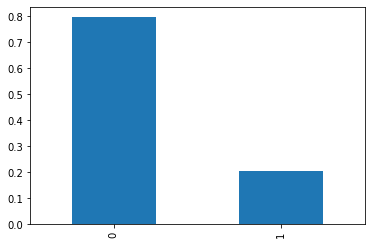

In [40]:
class_frequency = y.value_counts(normalize=True)
class_frequency.plot(kind='bar')
plt.show()

Видим, что наблюдается явный дисбаланс классов. Положительных объектов 20% во всей выборки, а отрицательных, соотвественно, - 80%.

Также посмотрим на баланс классов в обучающей выборке.

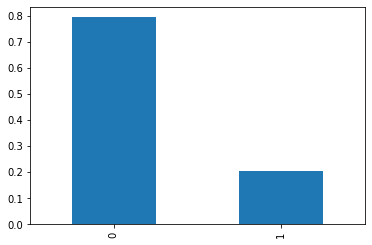

In [41]:
class_frequency = y_train.value_counts(normalize=True)
class_frequency.plot(kind='bar')
plt.show()

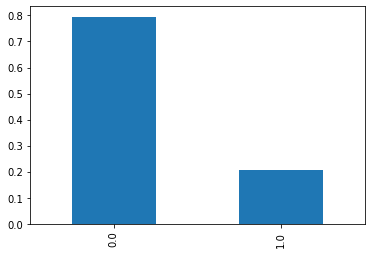

In [42]:
class_frequency = yo_train.value_counts(normalize=True)
class_frequency.plot(kind='bar')
plt.show()

Аналогично.

В данном проекте используем такие алгоритмы классификации машинного обучения как Logisitic Regression, Random Forest.

### Logistic Regression

In [43]:
model_lr = LogisticRegression(solver='liblinear', n_jobs=-1, random_state=7)

In [44]:
model_lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=-1, penalty='l2', random_state=7,
                   solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [45]:
y_predict = model_lr.predict(X_valid)
print(f'Метрика качества F1 без учета дисбаланаса на модели линейного классификатора: {f1_score(y_valid, y_predict)}')
y_predict_proba = model_lr.predict_proba(X_valid)
y_predict_proba_one = y_predict_proba[:, 1]
print(f'Метрика качества ROC-AUC без учета дисбаланаса на модели линейного классификатора: {roc_auc_score(y_valid, y_predict_proba_one)}')

Метрика качества F1 без учета дисбаланаса на модели линейного классификатора: 0.3148148148148148
Метрика качества ROC-AUC без учета дисбаланаса на модели линейного классификатора: 0.7722881130063965


### Random Forest

In [46]:
for depth in range(1, 20, 1):
    model_rf = RandomForestClassifier(max_depth=depth, n_estimators=100, random_state=7, n_jobs=-1)    
    model_rf.fit(Xo_train, yo_train)
    y_predict = model_rf.predict(Xo_valid)
    print(f'Для глубины: {depth}')
    print(f'Метрика качества F1 без учета дисбаланаса на модели случайного леса: {f1_score(yo_valid, y_predict)}')
    y_predict_proba = model_rf.predict_proba(Xo_valid)
    y_predict_proba_one = y_predict_proba[:, 1]
    print(f'Метрика качества ROC-AUC без учета дисбаланаса на модели случайного леса: {roc_auc_score(yo_valid, y_predict_proba_one)}')
    print()

Для глубины: 1
Метрика качества F1 без учета дисбаланаса на модели случайного леса: 0.0
Метрика качества ROC-AUC без учета дисбаланаса на модели случайного леса: 0.779317697228145



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Для глубины: 2
Метрика качества F1 без учета дисбаланаса на модели случайного леса: 0.15094339622641506
Метрика качества ROC-AUC без учета дисбаланаса на модели случайного леса: 0.8084624708092192

Для глубины: 3
Метрика качества F1 без учета дисбаланаса на модели случайного леса: 0.26898047722342733
Метрика качества ROC-AUC без учета дисбаланаса на модели случайного леса: 0.8170261574779165

Для глубины: 4
Метрика качества F1 без учета дисбаланаса на модели случайного леса: 0.35080645161290325
Метрика качества ROC-AUC без учета дисбаланаса на модели случайного леса: 0.8247728195755913

Для глубины: 5
Метрика качества F1 без учета дисбаланаса на модели случайного леса: 0.4285714285714285
Метрика качества ROC-AUC без учета дисбаланаса на модели случайного леса: 0.8311598893288659

Для глубины: 6
Метрика качества F1 без учета дисбаланаса на модели случайного леса: 0.48028673835125446
Метрика качества ROC-AUC без учета дисбаланаса на модели случайного леса: 0.8389128972484516

Для глубины

Видим, что обе метрики прямопропорциональны друг другу. Увеличвает одно, увеличивает другая, и наоборот. Наибольшее значение метрик достигается при глубине 15. Однако возьмем глубину 14, так как на 16 идет уменьшение метрик, что может быть синалом к тому, что модель начала переобучаться. Так мы задаем побольше свободы для уникальных случаев в тестовых и валидационных выборках, которых не было во время обучения.

На самом деле преимущество случайного леса в том, что он не подвержен переобучение при любом количестве деревьев. Чем больше деревьев будет принимать участие в голосование тем, качество окажется выше, однако время обучения от этого увеличится. Зададим гиперпараметр количества деревьев 300.

In [47]:
model_rf = RandomForestClassifier(max_depth=14, n_estimators=300, random_state=7, n_jobs=-1)    
model_rf.fit(Xo_train, yo_train)
y_predict = model_rf.predict(Xo_valid)
print(f'Метрика качества F1 без учета дисбаланаса на модели случайного леса: {f1_score(yo_valid, y_predict)}')
y_predict_proba = model_rf.predict_proba(Xo_valid)
y_predict_proba_one = y_predict_proba[:, 1]
print(f'Метрика качества ROC-AUC без учета дисбаланаса на модели случайного леса: {roc_auc_score(yo_valid, y_predict_proba_one)}')

Метрика качества F1 без учета дисбаланаса на модели случайного леса: 0.5451559934318555
Метрика качества ROC-AUC без учета дисбаланаса на модели случайного леса: 0.8452412681490505


В итоге, имеем, что лучшая модель - случайный лес с метриками качества на валидационной выборке:
- F1: 0.5451;
- ROC-AUC: 0.845.

## Борьба с дисбалансом

Существует несколько способов решить проблему дисбаланса классов:
- взвешивание классов;
- увеличение выборки;
- уменьшение выборки;
- изменение порога вероятности.

Попробуем использовать все подходы борьбы с дисбалансом и отберем тот, при котором метрики качества будут наибольшими.

### Взвешивание классов

Для этого задаем гиперпараметр class_weight='balanced'.

In [48]:
model_rf = RandomForestClassifier(max_depth=14, n_estimators=300, random_state=7, n_jobs=-1, class_weight='balanced')    
model_rf.fit(Xo_train, yo_train)
y_predict = model_rf.predict(Xo_valid)
print(f'Метрика качества F1 с учетом дисбаланаса на модели случайного леса: {f1_score(yo_valid, y_predict)}')
y_predict_proba = model_rf.predict_proba(Xo_valid)
y_predict_proba_one = y_predict_proba[:, 1]
print(f'Метрика качества ROC-AUC с учетом дисбаланаса на модели случайного леса: {roc_auc_score(yo_valid, y_predict_proba_one)}')

Метрика качества F1 с учетом дисбаланаса на модели случайного леса: 0.5622119815668203
Метрика качества ROC-AUC с учетом дисбаланаса на модели случайного леса: 0.8454855822926184


Видим, увеличение метрики F1!

### Увеличение выборки (upsampling)

In [49]:
def upsample(X, y, repeat):
    X_zeros = X[y == 0]
    X_ones = X[y == 1]
    y_zeros = y[y == 0]
    y_ones = y[y == 1]
    
    X_upsampled = pd.concat([X_zeros] + [X_ones] * repeat)
    y_upsampled = pd.concat([y_zeros] + [y_ones] * repeat)
    
    X_upsampled, y_upsampled = shuffle(X_upsampled, y_upsampled, random_state=7)
    
    return X_upsampled, y_upsampled

Чтобы уравнять число объекто в двух классов нужно увеличить число объектов в классе 1 примерно в 4 раза.

In [50]:
X_train_up, y_train_up = upsample(Xo_train, yo_train, 4)
model_rf = RandomForestClassifier(max_depth=14, n_estimators=300, random_state=7, n_jobs=-1)    
model_rf.fit(X_train_up, y_train_up)
y_predict = model_rf.predict(Xo_valid)
print(f'Увеличили выборку в 4 раз.')
print(f'Метрика качества F1 с учетом дисбаланаса на модели случайного леса: {f1_score(y_valid, y_predict)}')
y_predict_proba = model_rf.predict_proba(Xo_valid)
y_predict_proba_one = y_predict_proba[:, 1]
print(f'Метрика качества ROC-AUC с учетом дисбаланаса на модели случайного леса: {roc_auc_score(yo_valid, y_predict_proba_one)}')

Увеличили выборку в 4 раз.
Метрика качества F1 с учетом дисбаланаса на модели случайного леса: 0.5873015873015873
Метрика качества ROC-AUC с учетом дисбаланаса на модели случайного леса: 0.8460567062645955


При увеличении в 4 раза получаем наибольшую метрику F1 по сравнению с предыдущими.

### Уменьшение выборки (downsampling)

Данный подход корректно использовать на больших объемах данных. Его использование ведет к риску того, что модель будет некачественной из-за потери важных объекто при уменьшении объектов в данных.

In [51]:
def downsample(X, y, fraction):
    X_zeros = X[y == 0]
    X_ones = X[y == 1]
    y_zeros = y[y == 0]
    y_ones = y[y == 1]
    
    X_downsampled = pd.concat([X_zeros.sample(frac=fraction, random_state=7)] + [X_ones])
    y_downsampled = pd.concat([y_zeros.sample(frac=fraction, random_state=7)] + [y_ones])
    
    X_downsampled, y_downsampled = shuffle(X_downsampled, y_downsampled, random_state=7)

    return X_downsampled, y_downsampled

Чтобы уравнять число объекто в двух классах нужно взять долю обеъектов класса 0, равную 0.25.

In [52]:
X_train_down, y_train_down = downsample(Xo_train, yo_train, 0.25)
model_rf = RandomForestClassifier(max_depth=14, n_estimators=300, random_state=7, n_jobs=-1)    
model_rf.fit(X_train_down, y_train_down)
y_predict = model_rf.predict(Xo_valid)
print(f'Для доли: 0.25')
print(f'Метрика качества F1 с учетом дисбаланаса на модели случайного леса: {f1_score(yo_valid, y_predict)}')
y_predict_proba = model_rf.predict_proba(Xo_valid)
y_predict_proba_one = y_predict_proba[:, 1]
print(f'Метрика качества ROC-AUC с учетом дисбаланаса на модели случайного леса: {roc_auc_score(yo_valid, y_predict_proba_one)}')

Для доли: 0.25
Метрика качества F1 с учетом дисбаланаса на модели случайного леса: 0.5588822355289422
Метрика качества ROC-AUC с учетом дисбаланаса на модели случайного леса: 0.8428996598639455


### Изменение порога вероятности

In [53]:
model_rf = RandomForestClassifier(max_depth=14, n_estimators=300, random_state=7, n_jobs=-1)    
model_rf.fit(Xo_train, yo_train)
probabilities = model_rf.predict_proba(Xo_valid)
probabilities_one = probabilities[:, 1]

for threshold in np.arange(0, 1, 0.1):
    y_predict = probabilities_one > threshold
    print(f'Для порога: {threshold}')
    print(f'Метрика качества F1 с учетом дисбаланаса на модели случайного леса: {f1_score(yo_valid, y_predict)}')
    y_predict_proba = model_rf.predict_proba(Xo_valid)
    y_predict_proba_one = y_predict_proba[:, 1]
    print(f'Метрика качества ROC-AUC с учетом дисбаланаса на модели случайного леса: {roc_auc_score(yo_valid, y_predict_proba_one)}')
    print()

Для порога: 0.0
Метрика качества F1 с учетом дисбаланаса на модели случайного леса: 0.3277591973244147
Метрика качества ROC-AUC с учетом дисбаланаса на модели случайного леса: 0.8452412681490505

Для порога: 0.1
Метрика качества F1 с учетом дисбаланаса на модели случайного леса: 0.47826086956521735
Метрика качества ROC-AUC с учетом дисбаланаса на модели случайного леса: 0.8452412681490505

Для порога: 0.2
Метрика качества F1 с учетом дисбаланаса на модели случайного леса: 0.5598455598455598
Метрика качества ROC-AUC с учетом дисбаланаса на модели случайного леса: 0.8452412681490505

Для порога: 0.30000000000000004
Метрика качества F1 с учетом дисбаланаса на модели случайного леса: 0.593939393939394
Метрика качества ROC-AUC с учетом дисбаланаса на модели случайного леса: 0.8452412681490505

Для порога: 0.4
Метрика качества F1 с учетом дисбаланаса на модели случайного леса: 0.5942857142857143
Метрика качества ROC-AUC с учетом дисбаланаса на модели случайного леса: 0.8452412681490505

Для 

При пороге 0.4 получаем наибольшее значение метрики F1 :)

В итоге, получаем, что наибольшее значение метрики F1 равно 0.5942 при этом ROC-AUC равно 0.8452. Использовалась модель случайного леса с 300 деревьями и глубиной 14. Дисбаланс классов решен с помощью изменения порога, где порог на уровне 0.4.

## Тестирование модели

In [54]:
probabilities = model_rf.predict_proba(Xo_test)
probabilities_one = probabilities[:, 1]

y_predict = probabilities_one > 0.4
print(f'Метрика качества F1 с учетом дисбаланаса на модели случайного леса: {f1_score(yo_test, y_predict)}')
print(f'Метрика качества ROC-AUC с учетом дисбаланаса на модели случайного леса: {roc_auc_score(yo_test, probabilities_one)}')

Метрика качества F1 с учетом дисбаланаса на модели случайного леса: 0.5975443383356072
Метрика качества ROC-AUC с учетом дисбаланаса на модели случайного леса: 0.8545352093697698


Получаем, что метрика F1 на тесте равна 0.5975, а ROC-AUC - 0.8545. Успех!